In [1]:
import cv2
import numpy as np

from skimage.feature import peak_local_max
#from skimage.morphology import watershed
from scipy import ndimage
from scipy.signal import savgol_filter

# My custom library of photoelastic tools
import sys
sys.path.append('/home/jack/workspaces/jupyter-workspace/pepe/')

from pepe.preprocess import checkImageType, lightCorrectionDiff
from pepe.preprocess import cannyEdgeDetection, laplacianEdgeDetection, sobelEdgeDetection, applyFilter

from pepe.analysis import gSquared
from pepe.tracking import houghCircle

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120

dataFolder = '/run/media/jack/Seagate Portable Drive/Research/SpaceJam/'

In [2]:
# Load in image, convert to gray scale, and Otsu's threshold
image = checkImageType(dataFolder + '2022-02-02_Calibration.bmp')
height, width = np.shape(image)[:2]

# For light correction, we want two separate images, one vertical and one horizontal
maskXBounds = [408, 740] # Found manually
maskYBounds = [338, 668] # Found manually

verticalMask = np.array([[int(i < maskXBounds[1] and i > maskXBounds[0]) for i in range(width)] for j in range(height)])
horizontalMask = np.transpose([[int(i < maskYBounds[1] and i > maskYBounds[0]) for i in range(height)] for j in range(width)])

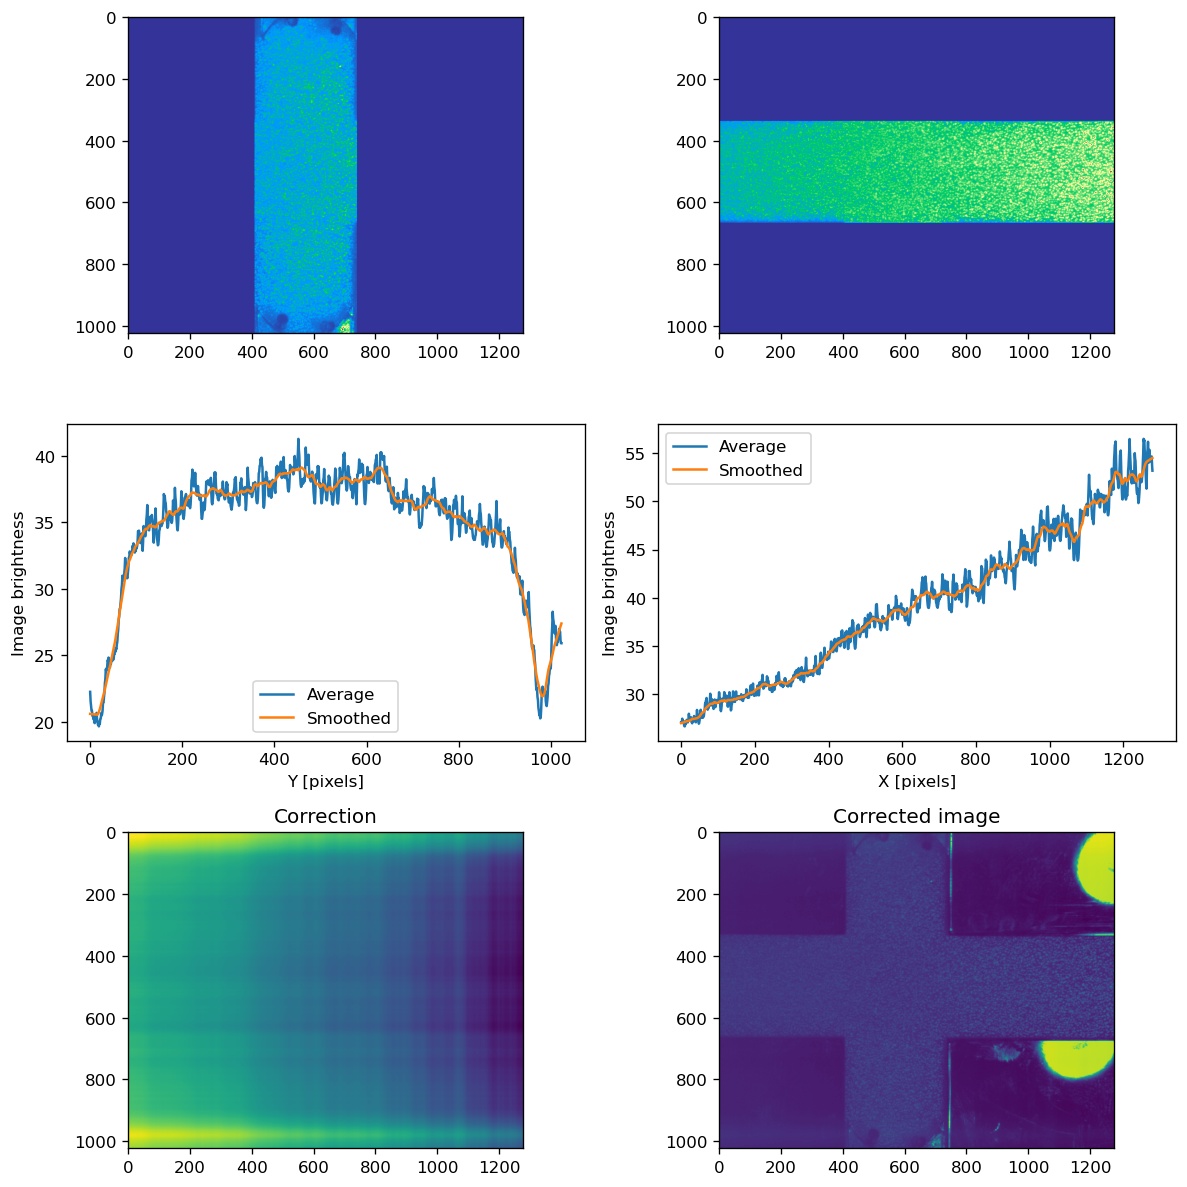

In [5]:
correction = lightCorrectionDiff(image, verticalMask, horizontalMask, debug=True)

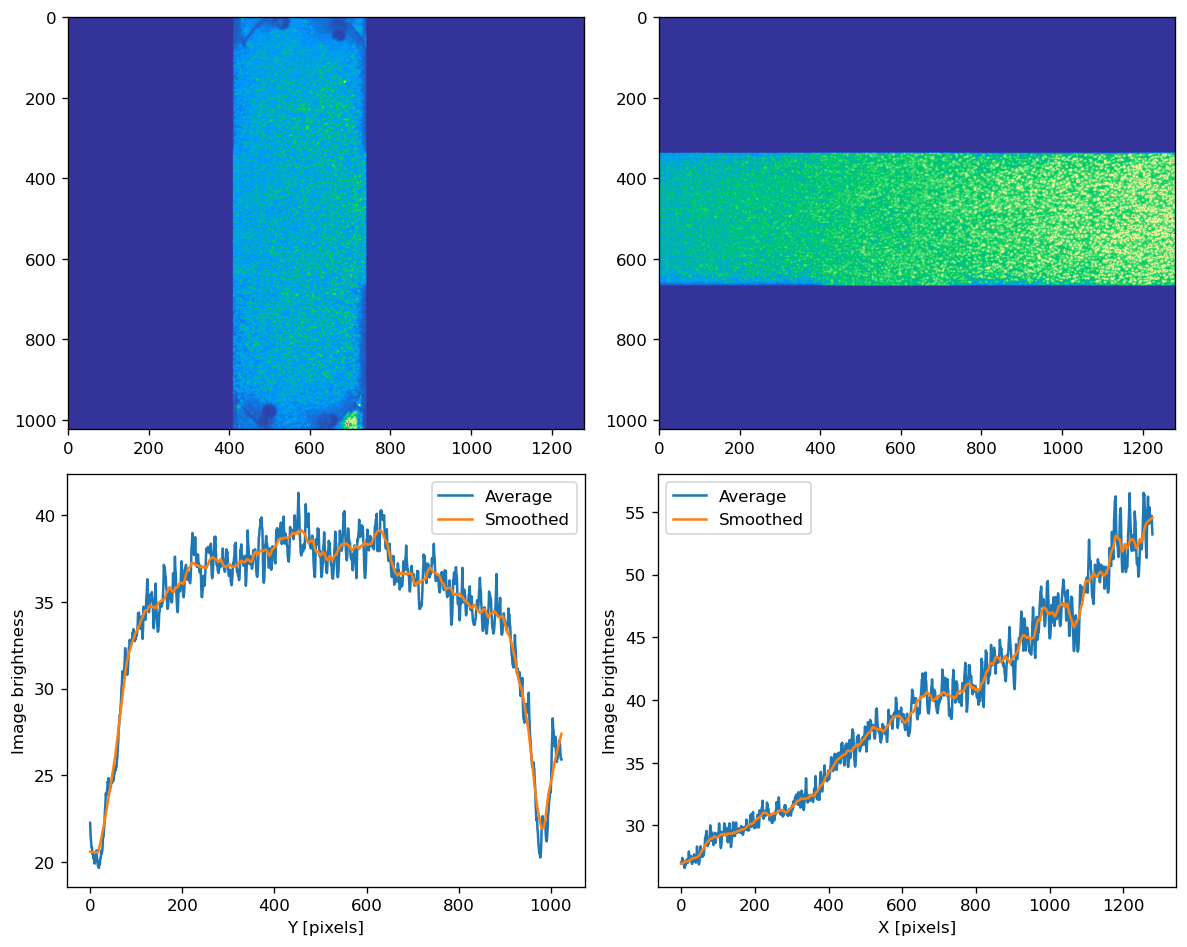

In [56]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

verticallyMasked = image[:,:,0] * verticalMask
horizontallyMasked = image[:,:,0] * horizontalMask

ax[0,0].imshow(verticallyMasked, cmap=plt.get_cmap('terrain'))
ax[0,1].imshow(horizontallyMasked, cmap=plt.get_cmap('terrain'))

# This excludes all values of zero, so that we get an actual pixel value we can directly add
brightnessByRow = np.nanmean(np.where(verticallyMasked != 0, verticallyMasked, np.nan), axis=1)
ax[1,0].plot(brightnessByRow, label='Average')
ax[1,0].set_ylabel('Image brightness')
ax[1,0].set_xlabel('Y [pixels]')

brightnessByColumn = np.nanmean(np.where(horizontallyMasked != 0, horizontallyMasked, np.nan), axis=0)
ax[1,1].plot(brightnessByColumn, label='Average')
ax[1,1].set_ylabel('Image brightness')
ax[1,1].set_xlabel('X [pixels]')

# Now smooth the two curves
kernel = 31
smoothedBrightnessByColumn = savgol_filter(brightnessByColumn, kernel, 1)
ax[1,1].plot(smoothedBrightnessByColumn, label='Smoothed')
ax[1,1].legend()

smoothedBrightnessByRow = savgol_filter(brightnessByRow, kernel, 1)
ax[1,0].plot(smoothedBrightnessByRow, label='Smoothed')
ax[1,0].legend()

fig.tight_layout()
plt.show()

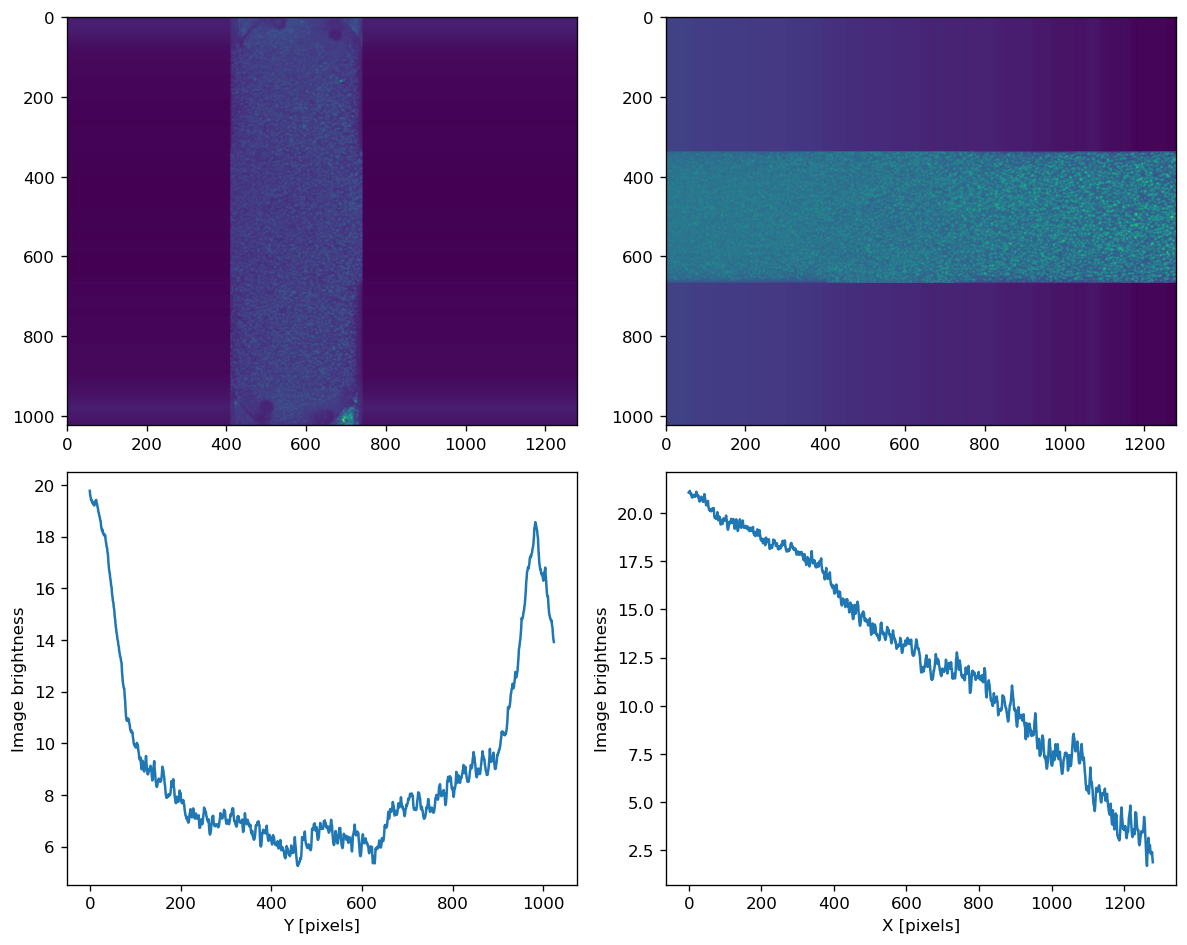

In [57]:
## Now calculate the correction
horizontalCorrection = np.mean(smoothedBrightnessByColumn) - smoothedBrightnessByColumn
correctedHorizontalImg = horizontallyMasked + np.repeat([horizontalCorrection], height, axis=0)
# Reapply the gradient
#correctedHorizontalImg *= horizontalMask

verticalCorrection = np.mean(smoothedBrightnessByRow) - smoothedBrightnessByRow
correctedVerticalImg = verticallyMasked + np.transpose(np.repeat([verticalCorrection], width, axis=0))
#correctedVerticalImg *= verticalMask

fig, ax = plt.subplots(2, 2, figsize=(10, 8))

ax[0,0].imshow(correctedVerticalImg)
ax[0,1].imshow(correctedHorizontalImg)

# This excludes all values of zero, so that we get an actual pixel value we can directly add
brightnessByRow = np.nanmean(np.where(correctedVerticalImg != 0, correctedVerticalImg, np.nan), axis=1)
ax[1,0].plot(brightnessByRow)
ax[1,0].set_ylabel('Image brightness')
ax[1,0].set_xlabel('Y [pixels]')

brightnessByColumn = np.nanmean(np.where(correctedHorizontalImg != 0, correctedHorizontalImg, np.nan), axis=0)
ax[1,1].plot(brightnessByColumn)
ax[1,1].set_ylabel('Image brightness')
ax[1,1].set_xlabel('X [pixels]')

fig.tight_layout()
plt.show()

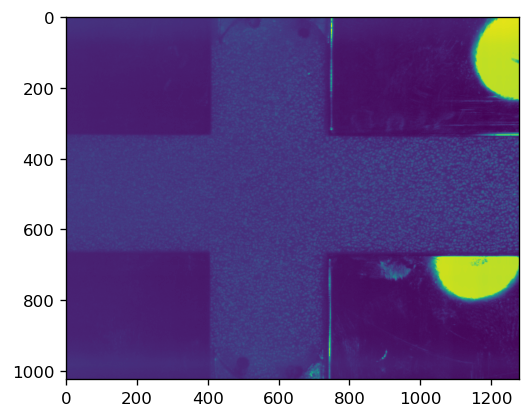

In [59]:
totalCorrection = np.add.outer(verticalCorrection, horizontalCorrection)

plt.imshow(totalCorrection + image[:,:,0])
plt.show()